In [1]:
from molmap import model as molmodel
import molmap

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def get_attentiveFP_idx(df, file = './split_and_data/06_HIV_attentiveFP.data'):
    """ attentiveFP dataset"""
    train, valid,test = load(file)
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

RDKit WARNING: [20:14:03] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')

In [3]:
task_name = 'HIV'
from chembench import load_data
df, _ = load_data(task_name)

train_idx, valid_idx, test_idx = get_attentiveFP_idx(df) 
len(train_idx), len(valid_idx), len(test_idx)

loading dataset: HIV number of split times: 3
training set: 32598, valid set: 4075, test set 4075
training set: 32598, valid set: 4075, test set 4075


(32598, 4075, 4075)

In [4]:
tmp_feature_dir = '../02_OutofTheBox_benchmark_comparison_DMPNN/tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

    
smiles_col = df.columns[0]
values_col = df.columns[1:]
Y = df[values_col].astype('float').values
Y = Y.reshape(-1, 1)


X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]

In [5]:
def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights


prcs_metrics = ['MUV', 'PCBA']

In [6]:
print(len(train_idx), len(valid_idx), len(test_idx))

trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]            

32598 4075 4075


In [7]:
epochs = 800
patience = 10 #early stopping

dense_layers = [256, 128]

batch_size = 128
lr = 1e-4
weight_decay = 0

monitor = 'val_loss'
dense_avf = 'relu'
last_avf = None #sigmoid in loss

if task_name in prcs_metrics:
    metric = 'PRC'
else:
    metric = 'ROC'

In [8]:
results = []
for i, seed in enumerate([7, 77, 77]):

    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)

    pos_weights, neg_weights = get_pos_weights(trainY)
    loss = lambda y_true, y_pred: molmodel.loss.weighted_cross_entropy(y_true,y_pred, pos_weights, MASK = -1)

    model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                       n_outputs=Y.shape[-1], 
                                       dense_layers=dense_layers, 
                                       dense_avf = dense_avf, 
                                       last_avf=last_avf)

    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
    #import tensorflow_addons as tfa
    #opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = loss)
    
    if i == 0:
        performance = molmodel.cbks.CLA_EarlyStoppingAndPerformance((trainX, trainY), 
                                                                       (validX, validY), 
                                                                       patience = patience, 
                                                                       criteria = monitor,
                                                                       metric = metric,
                                                                      )
        model.fit(trainX, trainY, batch_size=batch_size, 
              epochs=epochs, verbose= 0, shuffle = True, 
              validation_data = (validX, validY), 
              callbacks=[performance]) 


    else:
        model.fit(trainX, trainY, batch_size=batch_size, 
              epochs = performance.best_epoch + 1, verbose = 1, shuffle = True, 
              validation_data = (validX, validY)) 
            
    performance.model.set_weights(model.get_weights())
    
    best_epoch = performance.best_epoch
    trainable_params = model.count_params()
    
    train_aucs = performance.evaluate(trainX, trainY)            
    valid_aucs = performance.evaluate(validX, validY)            
    test_aucs = performance.evaluate(testX, testY)


    final_res = {
                     'task_name':task_name,            
                     'train_auc':np.nanmean(train_aucs), 
                     'valid_auc':np.nanmean(valid_aucs),                      
                     'test_auc':np.nanmean(test_aucs), 
                     'metric':metric,
                     '# trainable params': trainable_params,
                     'best_epoch': best_epoch,
                     'batch_size':batch_size,
                     'lr': lr,
                     'weight_decay':weight_decay
                    }
    
    results.append(final_res)

epoch: 0001, loss: 1.2272 - val_loss: 0.9984; auc: 0.7653 - val_auc: 0.7462                                                                                                    
epoch: 0002, loss: 1.1208 - val_loss: 0.9248; auc: 0.8049 - val_auc: 0.7852                                                                                                    
epoch: 0003, loss: 1.0363 - val_loss: 0.9350; auc: 0.8259 - val_auc: 0.7828                                                                                                    
epoch: 0004, loss: 0.9919 - val_loss: 0.8627; auc: 0.8657 - val_auc: 0.8086                                                                                                    
epoch: 0005, loss: 0.9168 - val_loss: 0.9333; auc: 0.8908 - val_auc: 0.8118                                                                                                    
epoch: 0006, loss: 0.8659 - val_loss: 0.8450; auc: 0.9100 - val_auc: 0.8165                                             

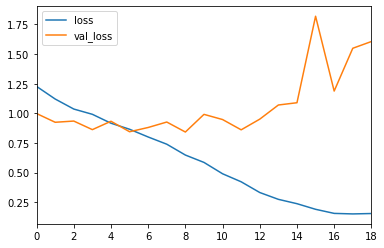

In [9]:
pd.DataFrame(performance.history)[['loss', 'val_loss']].plot()

In [10]:
pd.DataFrame(results).test_auc.mean()

0.8652147464318892

In [11]:
pd.DataFrame(results).test_auc.std()

0.0030805642037164413

In [12]:
pd.DataFrame(results)

,task_name,train_auc,valid_auc,test_auc,metric,# trainable params,best_epoch,batch_size,lr,weight_decay
0,HIV,0.969231,0.833755,0.861667,ROC,799649,8,128,0.0001,0
1,HIV,0.966617,0.814389,0.866764,ROC,799649,8,128,0.0001,0
2,HIV,0.967272,0.811450,0.867213,ROC,799649,8,128,0.0001,0


In [13]:
pd.DataFrame(results).to_csv('./results/%s.csv' % task_name)